# Cifar10 Classification

Until now, we have implemented several pieces of a deep learning pipeline and trained a two-layer neural network, but all hyperparameters were pre-set to values yielding resonable results. However, in real problems a large part of the work will be geared towards finding the best hyperparameter settings for a certain problem. In this notebook we will explore some good practices for network debugging and hyperparameters search, as well as extending our binary classification neural network to a multi-class one.

Let's go!

**Note 1**: This exercise is quite heavy with computations. We recommend using Google-Colab.

**Note 2**: This exercise take time, so start early!!

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [3]:
"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_06'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_06'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

In [4]:
# Some lengthy setup.
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

from exercise_code.networks.layer import (
    Sigmoid, 
    Relu, 
    LeakyRelu, 
    Tanh,
)
from exercise_code.data import (
    DataLoader,
    ImageFolderDataset,
    MemoryImageFolderDataset,
    RescaleTransform,
    NormalizeTransform,
    FlattenTransform,
    ComposeTransform,
)
from exercise_code.data.image_folder_dataset import RandomHorizontalFlip
from exercise_code.networks import (
    ClassificationNet,
    BCE,
    CrossEntropyFromLogits
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

# 1. Quick recap (and some new things)

Until now, in the previous exercises, we focused on building and understanding all the necessary modules for training a simple model. We followed the Pytorch implementations closely, as this is the framework we will use later and we wanted you to have a smoother transition to its APIs. 

In the figure below you can see the main components in Pytorch. Let's start with a quick recap of **our implementation** of these components. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Everything is already implemented for this part, but we <b>strongly</b> encourage you to check  the respective source files in order to have a better understanding. </p>
</div>

<img src="https://cdn-images-1.medium.com/max/800/1*uZrS4KjAuSJQIJPgOiaJUg.png" style="width: 500px;">

## 1.1 Dataset and Dataloader

Data preparation is an important part of deep learning projects. Because the data can come in different formats and from different sources, it must be prepared in a certain way, which depends on the application. One part, however, is uniform: since an entire dataset is usually too large to handle at once, we train our models on smaller batches of data. 

The goal of the ```Dataset``` class is to encapsulate all the 'dirty' data processing: loading and cleaning the data, storing features (or names of files where features can be found) and labels, as well as providing the means for accessing individual (transformed) items of the data using the ```__getitem__()``` function and an index. You already implemented an ```ImageFolderDataset``` (in ```exercise_code/data/image_folder_dataset.py```) class in Exercise 3. We we will reuse this class here.

For processing the data, you implemented several transforms in Exercise 3 (```RescaleTransform```, ```NormalizeTransform```, ```ComposeTransform```). In this exercise we are working with images, which are multidimensional arrays, but we are using a simple feedforward neural network which takes an one dimensional array as an input, so it is necessary to reshape the images before feeding them into the model. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the reshape operation in the <code>FlattenTransform</code> class, which can be found in <code>../exercise_06/exercise_code/data/image_folder_dataset.py</code>. </p>
</div>

In [5]:
download_url = "https://i2dl.vc.in.tum.de/static/data/cifar10.zip"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(i2dl_exercises_path, "datasets", "cifar10")

## The usual memory vs local data warning
If you are using google colab or store your files on a local HDD, iterating over dataset takes quite some time and blablabla. You know the drill by now ;).

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>Loading the whole dataset into memory will not work if you are using a machine with 4GB of RAM or less (depending on your other programs such as memory hungry web browsers). Consider closing some open programs or simply use the local on-demand ImageFolderDataset.</p>
    <p>In addition we want to warn you that everytime you execute a cell like "dataset2 = MemoryImageFolderDataset..." you are loading a 1.2GB matrix into your memory. If you do this often enough this notebook will crash on every machine. Therefore, we make sure to always use a single variable "dataset" which will be overwritten by future cells to avoid straining your memory too much.</p>
</div>

In [6]:
# Choose your preferred dataset here

# DATASET = ImageFolderDataset
DATASET = MemoryImageFolderDataset

Now that that is taken care of, back to the actual loading.

In [7]:
# Use the Cifar10 mean and standard deviation computed in Exercise 3.
cifar_mean = np.array([0.49191375, 0.48235852, 0.44673872])
cifar_std  = np.array([0.24706447, 0.24346213, 0.26147554])

# Define all the transforms we will apply on the images when 
# retrieving them.
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)
flatten_transform = FlattenTransform()
compose_transform = ComposeTransform([rescale_transform, 
                                      normalize_transform,
                                      flatten_transform])

# Create a train, validation and test dataset.
datasets = {}
for mode in ['train', 'val', 'test']:
    crt_dataset = DATASET(
        mode=mode,
        root=cifar_root, 
        transform=compose_transform,
        split={'train': 0.6, 'val': 0.2, 'test': 0.2}
    )
    datasets[mode] = crt_dataset

Then, based on this ```Dataset``` object, we can construct a ```Dataloader``` object which samples a random mini-batch of data at once. 

In [8]:
# Create a dataloader for each split.
dataloaders = {}
for mode in ['train', 'val', 'test']:
    crt_dataloader = DataLoader(
        dataset=datasets[mode],
        batch_size=256,
        shuffle=True,
        drop_last=True,
    )
    dataloaders[mode] = crt_dataloader

Because the ```Dataloader``` has the ```__iter__()``` method, we can simply iterate through the batches it produces, like this:

```python
for batch in dataloader['train']:
    do_something(batch)
```

## 1.2 Data Augmentation

After the preprocessing steps, our data is in a good shape and ready to be fed into our network. As explained in the chapter above, we used the transformation functions `RescaleTransform`, `NormalizeTransform` and `FlattenTransform` to achieve this shape. These are the general steps that you need to perform on the data before you can start training. Of course, all these steps have to be applied to our three dataset splits (train, val and test split). In other words, preprocessing involves preparing the data before is can be used for training and inference. 

Besides these basic transformations, there are many other transformation methods that you can apply to the images. For example, you can <b>flip the images horizontally</b> or <b>blur the images</b> and use these new images to enlarge the dataset. This idea is called Data Augmentation and it involves methods that alter the training images to generate a synthetic dataset that is larger than your original dataset. This will hopefully improve the performance of your model. There is one important difference between data augmentation and data preprocessing: The transformation methods used to enlarge your dataset should only be applied to the training data. The validation and test data should not be affected by these methods.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>The choice of transformation methods for data augmentation can be seen as a hyperparameter of your model. You can try to include these to enlarge your training data and obtain better results for your model. In <code>exercise_code/data/image_folder_dataset.py</code> we implemented the function <code>RandomHorizontalFlip</code> for you, which is randomly flipping an image horizontally. Check out the implementation.</p>
    <p> Later, we will perform hyperparameter tuning. In order to improve your model's performance, you can include some other data augmentation methods. Feel free to play around and to implement other methods as for example Gaussian Blur or Rotation. </p>       
</div>

Let us quickly check the `RandomHorizontalFlip` method with an image of the Cifar10 dataset in the following cell.

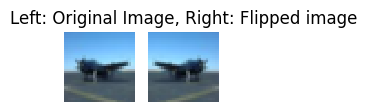

In [9]:
#Load the data in a dataset without any transformation 
dataset = DATASET(
        mode=mode,
        root=cifar_root, 
        download_url=download_url,
        split={'train': 0.6, 'val': 0.2, 'test': 0.2},
    )

#Retrieve an image from the dataset and flip it
image = dataset[1]['image']
transform = RandomHorizontalFlip(1)
image_flipped = transform(image)

#Show the two images
plt.figure(figsize = (2,2))
plt.subplot(1, 2, 1)
plt.imshow(image.astype('uint8'))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_flipped.astype('uint8'))
plt.axis('off')
plt.title("Left: Original Image, Right: Flipped image")
plt.show()

## 1.3 Layers

Now, that the data is prepared, we can take a look at the model we are using. In our case it will be a neural network. 

In Exercise 5, you implemented a simple 2-layer neural network that had a hidden size as a parameter:

$$ 
{\hat{y}} = \sigma(\sigma({x W_1} + {b_1}) {W_2} + {b_2}) 
$$

where $ \sigma({x}) $ was the sigmoid function, $ {x} $ was the input, $ {W_1}, {W_2} $ the weight matrices and $ {b_1}, {b_2}$ the biases for the two layers.

This is how we used this network:

In [10]:
input_size = datasets['train'][0]['image'].shape[0]
model = ClassificationNet(input_size=input_size, 
                          hidden_size=512)

Note that we updated the ```ClassificationNet``` from the previous exercise. Now you can customize the number of outputs, the choice of activation function, the hidden size etc. We encourage you to check the implementation in ```exercise_code/networks/classification_net.py``` 

In [11]:
num_layer = 2
reg = 1e-6

model = ClassificationNet(activation=Relu, 
                          num_layer=num_layer, 
                          reg=reg,
                          num_classes=10)

Performing the forward and backward passes through the model was quite simple:

```python

# X is a batch of training features 
# X.shape = (batch_size, features_size)
y_out = model.forward(X)

# dout is the gradient of the loss function w.r.t the output of the network.
# dout.shape = (batch_size, )
model.backward(dout)
```

Just as the learning rate or the number of epochs we want to train for, the number of hidden layers and the number of units in each hidden layer are also hyperparameters that we can tune. In this notebook you can play with networks of different sizes to see the impact that the network capacity has.

Before we move on to the loss functions, let's have a look at the activation functions. The choice of an activation function can have a huge impact on the performance of the network you are designing. So far, you have implemented the `Sigmoid` and the `Relu` activation functions in Exercise 5. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Take a look at the <code>Sigmoid</code> and the <code>Relu</code> class in <code>exercise_code/networks/layer.py</code> and the implementation of the respective forward and backward passes. Make sure to understand why we used <b>element-wise product</b> instead of dot product in the backward pass of the <code>Sigmoid</code> class to compute the gradient <code>dx</code>. That will be helpful for your later implementation of other activation functions.</p>
    <p> <b>Note:</b> The <code>cache</code> variable is used to store information from the forward pass and then pass this information in the backward pass to make use of it there. The implementation of both classes shows that this variable can be used differently - depending on which information is needed in the backward pass. </p>
</div>

Now, we want to have a look at two other, very common activation functions that you have already seen in the lecture: Leaky ReLU activation function and Tanh activation function. 

**Leaky Relus** are one attempt to fix the “dying ReLU” problem. Instead of the function being zero when $ x < 0 $, a leaky ReLU has a small negative slope (for example, 0.01).  The function computes $f(x) = \mathbb{1}(x < 0) (\alpha x) + \mathbb{1}(x>=0) (x)$ where $\alpha$ is a small constant. Some people report success with this form of activation function, but the results are not always consistent.

The **tanh non-linearity** squashes a real-valued number into the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the tanh non-linearity is always preferred to the sigmoid non-linearity. Also note that the tanh neuron is simply a scaled sigmoid neuron, in particular the following holds: $\tanh(x) = 2 \cdot \sigma(2x) -1$.

<img class=left src=https://pytorch.org/docs/stable/_images/LeakyReLU.png alt="Figure3" width="350" align='left'/> 
<img class=right src=https://pytorch.org/docs/stable/_images/Tanh.png alt="Figure4" width="350"/>

<div class="alert alert-info">
    <h3>Task: Implement Activation Layers</h3>
    <p> Now, it is your turn to implement the <code>LeakyRelu</code> and the <code>Tanh</code> class in <code>exercise_code/networks/layer.py</code> by completing the <code>forward</code> and the <code>backward</code> functions. You can test your implementation in the following two cells. </p>
    <p> <b>Note:</b> Always remember to return a cache in <code>forward</code> for later backpropagation in <code>backward</code>. As we have seen above, the <code>cache</code> variable can be used differently for two activation functions.</p>
</div>

Use this cell to test your implementation of the `LeakyRelu` class:

In [12]:
from exercise_code.tests.layer_tests import *
LeakyReluTestWrapper()()


####### Testing LeakyReluTest Started #######

Test LeakyReluForwardTest: passed!
Test LeakyReluBackwardTest: passed!

####### Testing LeakyReluTest Finished #######
Test LeakyReluTest: passed! -->  Tests passed: 2/2
Score: 100/100


And this cell to test your implementation of the `Tanh` class:

In [13]:
TanhTestWrapper()()


####### Testing TanhTest Started #######

Test TanhForwardTest: passed!
Test TanhBackwardTest: passed!

####### Testing TanhTest Finished #######
Test TanhTest: passed! -->  Tests passed: 2/2
Score: 100/100


Congratulations, you implemented four different activation functions! These activation layers are now ready to be used when you start building your own network.

## 1.4 Loss

In order to measure how well a network is performing, we implemented several ```Loss``` classes (```L1```, ```MSE```, ```BCE```, each preferred for a certain type of problems) in ```exercise_code/networks/loss.py```.

Each contains a ```forward()``` method, which outputs a number we can use as a measure for our network's performance. 

Since our goal is to change the weights of the network in a way that this loss measure decreases, we are also interested in the gradients of the loss w.r.t the outputs of the network, $ \nabla_{\hat{y}} L({\hat{y}}, {y}) $. This was implemented in ```backward()```. 

In previous exercises, we worked on binary classification problems and therefore used binary cross entropy (```BCE```) as a loss function.

$$ BCE(\hat{y}, y) = - \frac{1}{N} \sum_{i=1}^N \Big(y_i \log(\hat{y_i}) + (1-y_i) \log(1 - \hat{y_i}) \Big) $$ 

where
- $ N $ was the number of samples we were considering
- $\hat{y}_i$ was the network's prediction for sample $i$. Note that this was a valid probability $\in [0, 1]$, because we applied a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation on the last layer. 
- $ y_i $ was the ground truth label (0 or 1, depending on the class)

Since we have 10 classes in the CIFAR10 dataset, we need a generalization of the binary cross entropy loss to multiple classes. This generalization is called the cross entropy loss and is defined as:
$$ CE(\hat{y}, y) = - \frac{1}{N} \sum_{i=1}^N \sum_{k=1}^{C} \Big(y_{ik} \log(\hat{y}_{ik}) \Big) $$

where:
- $ N $ is the number of samples
- $ C $ is the number of classes
- $ \hat{y}_{ik} $ is the probability that the model assigns for the $k$th class when the $i$th sample is the input. **Because we don't apply any activation function on the last layer of our network, its outputs for each sample will not be a valid probability distribution over the classes. We call these the raw outputs of the network '[logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045)' and we will apply a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation in order to obtain a valid probability distribution.** 
- $y_{ik} = 1 $ iff the true label of the $i$th sample is $k$ and 0 otherwise. This is called a [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

You can check for yourself that if the number of classes $ C $ is 2, the binary cross entropy is actually equivalent to the cross entropy.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the <code>CrossEntropyFromLogits</code> class, which can be found in <code>../exercise_06/exercise_code/networks/loss.py</code>. </p>
</div>

In [14]:
loss = CrossEntropyFromLogits

We can simply get the results of the forward and backward passes as follows:

```python
# y_out is the output of the neural network
# y_truth is the actual label from the dataset
loss.forward(y_out, y_truth)
loss.backward(y_out, y_truth)
```

## 1.5 Optimizer

Now that we know the gradient of the loss w.r.t the ouputs of the network, as well as the local gradient for each layer of the network, we can use the chain rule to compute all gradients. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>We implemented several optimizer classes <code>SGD</code>, <code>Adam</code>, <code>sgd_momentum</code> that use different first-order parameter update rules. Those can be found in <code>../exercise_06/exercise_code/networks/optimizer.py</code>. </p>
    <p>The <code>step()</code> method used, iterates through all the parameters of the model and updates them using the gradient information.</p>
</div>

What the optimizer is doing, in pseudocode, is the following:

```python
for param in model:
    # Use the gradient to update the weights.
    update(param)
    
    # Reset the gradient after each update.
    param.gradient = 0
```

```SGD``` had the simplest update rule:
```python
def update(param):
    param = param - learning_rate * param.gradient
```

For the more complicated update rules, see ```exercise_code/networks/optimizer.py```

## 1.6 Solver

The ```Solver``` is where all the above elements come together: Given a train and a validation dataloader, a model, a loss and an optimizer, it uses the training data to optimize a model in order to get better predictions. We simply call ```train()``` and it does its 'magic' for us!
```python
solver = Solver(model, 
                dataloaders['train'], 
                dataloaders['val'], 
                learning_rate=0.001, 
                loss_func=MSE(), 
                optimizer=SGD)

solver.train(epochs=epochs)
```

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check out the implementation of <code>train()</code> in <code>../exercise_06/exercise_code/solver.py</code>. </p>
</div>

## 1.7 Weight Regularization

Before finishing the recap, we want to take a look at some regularization methods that have been introduced in the lecture. Those can be helpful to improve the robustness of our model. In this chapter, we're talking about weight regularization methods.

Weight regularization (a.k.a "Weight Decay") has been introduced to you as a method preventing the model from overfitting to the training data. 

The regularization term over the weights of the network is added to the loss:

$$ L^* = \underbrace{L}_{\text{Overall loss}} + \underbrace{\lambda R(\theta)}_{\text{Regularization loss}} $$

where $\theta$ represents **ALL** the weights of the network, $\theta = \{W_1, \dots, W_n\}$ and $R(\theta) \in \mathbb{R}.$

Therefore, the backward step for each weight matrix $W_k \in  \theta$ is: 

$$\frac{\partial L}{\partial W_k}^* = \underbrace{\frac{\partial L}{\partial W_k}}_{\text{Gradient}}  + \underbrace{\lambda \frac{\partial R(\theta)}{\partial W_k}}_{\text{Reg. loss gradient}}$$

The usage of the regularization term encodes some preferences in manipulating the weights. In the lecture, we compared two weight regularization methods and their respective preference for weight vectors. We made the following observations: 

1. L1 regularization: Enforces sparsity 
2. L2 regularization: Enforces that weights have similar values

The most common weight regularization method is the L2 regularization. The L2 regularization prefers smaller and more diffuse weight vectors. Therefore, the model is encouraged to take all input dimensions into account rather than focusing strongly on a small number of input dimensions.

When using weight regularization, the loss function is a composition of two parts:

The first being the data loss, which is calculated using Cross Entropy loss in our model. The second part is called the regularization loss $R(\theta)$ and is computed in the L2 case as follows:
$$R(\theta) = \sum_{k} \sum_{i} \sum_{j} w_{k,i,j}^2$$

Where $k$ runs over all weight matrices in the network, and $i, j$ correspond to the spatial height and width of each weight matrix $W_k$.

# 2. An overview of hyperparameters


<img src=https://images.deepai.org/glossary-terms/05c646fe1676490aa0b8cab0732a02b2/hyperparams.png alt=hyperparameter width=700>

A **hyperparameter** is a parameter that is set before the learning process begins. Recall that the parameters of the weight matrix and the bias vector are learned during the learning process.

The hyperparameter settings are essential, since they control and affect the whole training and therefore have a great impact on the model's performance. 

Some hyperparameters we have covered in lectures are:
* Network architecture
    * Choice of activation function
    * Number of layers
    * ...
* Learning rate
* Number of epochs
* Batch size
* Regularization strength
* Momentum
* ...

## 2.1 Start debugging your own network!

As already suggested in the lectures, you should always start from small and simple architectures, to make sure you are going the right way. 

As a first step you should try to overfit to a single training sample, then to a few batches of training samples and finally go deeper with larger neural networks and the whole training data.

We provide a default neural network (i.e. ClassificationNet) with arbitrary number of layers, which is a generalization from a fixed 2-layer neural network in exercise 5. You are welcome to implement your own network, in that case just implement **MyOwnNetwork** in ```exercise_code/networks/classification_net.py```. You can also copy things from ClassficationNet and make little adjustments to your own network. Either way, just pick one network and comment out the other one, then run the cells below for debugging.

<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>Please, make sure you don't modify the ClassificationNet itself. In this way you can always have a working network to fall back on.</p>
    <p>In order to pass this submissions, you can <b>first stick to the default ClassificationNet implementation without changing any code at all</b>. The goal of this submission is to find reasonable hyperparameters and the parameter options of the ClassificationNet are broad enough to pass.</p>
    <p>Once you have surpassed the submission goal, you can try to implement additional activation functions in the accompanying notebook, try different weight initializations or make other adjustments by writing your own network architecture in the MyOwnNetwork class.</p>
</div>

First, let's start with a 2-layer neural network, and overfit to one single training sample.

After training, let's evaluate the training process by plotting the loss curves.

In [15]:
from exercise_code.solver import Solver
from exercise_code.networks.optimizer import SGD, Adam
from exercise_code.networks import MyOwnNetwork

num_layer = 2
epochs = 20
reg = 1e-6
batch_size = 4

model = ClassificationNet(num_layer=num_layer, reg=reg)
# model = MyOwnNetwork()

loss = CrossEntropyFromLogits

# Make a new data loader with a single training image
overfit_dataset = DATASET(
    mode='train',
    root=cifar_root, 
    download_url=download_url,
    transform=compose_transform,
    limit_files=1
)
dataloaders['train_overfit_single_image'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)


# Decrease validation data for only debugging
debugging_validation_dataset = DATASET(
    mode='val',
    root=cifar_root, 
    download_url=download_url,
    transform=compose_transform,
    limit_files=100
)
dataloaders['val_500files'] = DataLoader(
    dataset=debugging_validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

solver = Solver(model, dataloaders['train_overfit_single_image'], dataloaders['val_500files'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 20) train loss: 2.297071; val loss: 2.306355
(Epoch 2 / 20) train loss: 2.182829; val loss: 2.311383
(Epoch 3 / 20) train loss: 2.040154; val loss: 2.318081
(Epoch 4 / 20) train loss: 1.870841; val loss: 2.326746
(Epoch 5 / 20) train loss: 1.687636; val loss: 2.337719
(Epoch 6 / 20) train loss: 1.504726; val loss: 2.351271
(Epoch 7 / 20) train loss: 1.335505; val loss: 2.367585
(Epoch 8 / 20) train loss: 1.185235; val loss: 2.386815
(Epoch 9 / 20) train loss: 1.048617; val loss: 2.409132
(Epoch 10 / 20) train loss: 0.922046; val loss: 2.434665
(Epoch 11 / 20) train loss: 0.804986; val loss: 2.463446
(Epoch 12 / 20) train loss: 0.698867; val loss: 2.495375
(Epoch 13 / 20) train loss: 0.604541; val loss: 2.530231
(Epoch 14 / 20) train loss: 0.521376; val loss: 2.567703
(Epoch 15 / 20) train loss: 0.448663; val loss: 2.607401
(Epoch 16 / 20) train loss: 0.385675; val loss: 2.648878
(Epoch 17 / 20) train loss: 0.331568; val loss: 2.691661
(Epoch 18 / 20) train loss: 0.285409; va

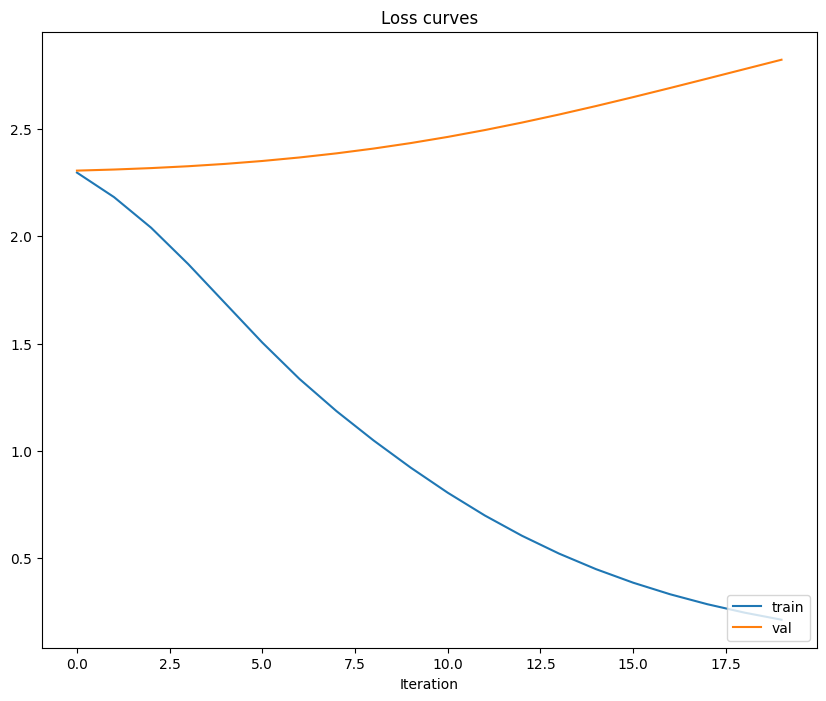

In [16]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [17]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_single_image'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))

Training accuray: 1.00000
Validation accuray: 0.07000


This time we want to overfit to a small set of training batch samples. Please observe the difference from above. 

In [18]:
from exercise_code.networks import MyOwnNetwork

num_layer = 2
epochs = 100
reg = 0.1
num_samples = 10

model = ClassificationNet(num_layer=num_layer, reg=reg)
# model = MyOwnNetwork()

loss = CrossEntropyFromLogits

# Make a new data loader with a our num_samples training image
overfit_dataset = DATASET(
    mode='train',
    root=cifar_root, 
    download_url=download_url,
    transform=compose_transform,
    limit_files=num_samples
)
dataloaders['train_overfit_10samples'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)

solver = Solver(model, dataloaders['train_overfit_10samples'], dataloaders['val_500files'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 100) train loss: 2.285654; val loss: 2.339864
(Epoch 2 / 100) train loss: 2.184179; val loss: 2.404058
(Epoch 3 / 100) train loss: 2.073793; val loss: 2.462862
(Epoch 4 / 100) train loss: 1.897433; val loss: 2.519303
(Epoch 5 / 100) train loss: 1.947012; val loss: 2.604608
(Epoch 6 / 100) train loss: 1.825010; val loss: 2.652202
(Epoch 7 / 100) train loss: 1.797096; val loss: 2.726142
(Epoch 8 / 100) train loss: 1.650958; val loss: 2.821884
(Epoch 9 / 100) train loss: 1.715406; val loss: 2.899799
(Epoch 10 / 100) train loss: 1.778572; val loss: 2.929512
(Epoch 11 / 100) train loss: 1.680088; val loss: 2.936305
(Epoch 12 / 100) train loss: 1.626903; val loss: 3.065746
(Epoch 13 / 100) train loss: 1.608086; val loss: 3.175972
(Epoch 14 / 100) train loss: 1.668271; val loss: 3.193894
(Epoch 15 / 100) train loss: 1.583900; val loss: 3.144835
(Epoch 16 / 100) train loss: 1.663721; val loss: 3.157860
(Epoch 17 / 100) train loss: 1.707083; val loss: 3.212566
(Epoch 18 / 100) train 

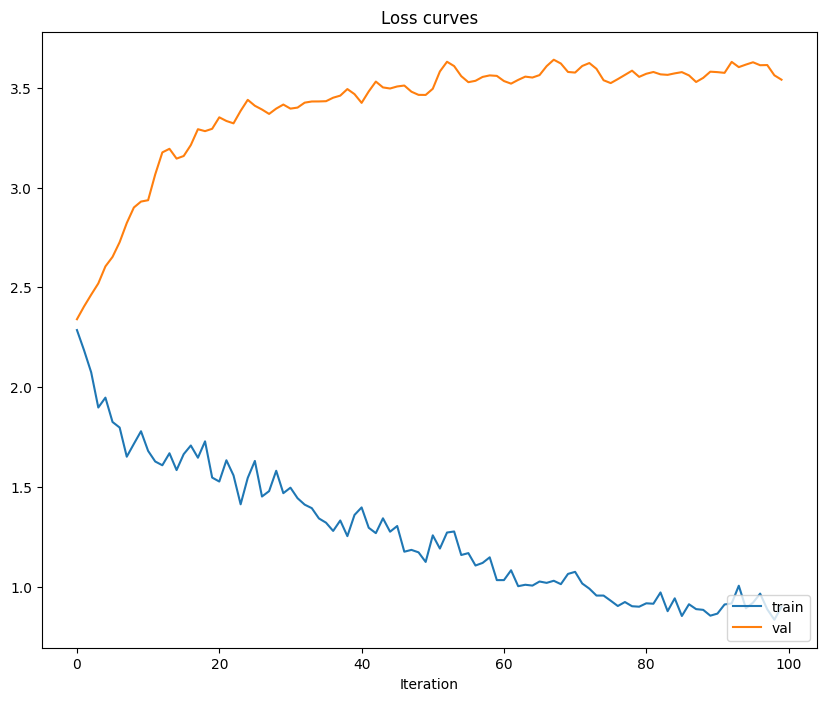

In [19]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [20]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_10samples'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))

Training accuray: 1.00000
Validation accuray: 0.07000


If you're overfitting to the training data, that means the network's implementation is correct. However, as you have more samples to overfit, your accuracy will be way lower. You can increase the number of epochs above to achieve better results.

Now let's try to feed all the training and validation data into the network, but this time let's set compare a 2-layer and a 5-layer network, using the same hyperparameters.

<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>This may take about 1 min per epoch as the training set is quite large. For convenience, we are now only using 1000 images for training but use the full validation set.</p>
</div>

In [21]:
from exercise_code.networks import MyOwnNetwork

num_layer = 2
epochs = 5
reg = 1e-4

# Make a new data loader with 1000 training samples
num_samples = 500
overfit_dataset = DATASET(
    mode='train',
    root=cifar_root, 
    download_url=download_url,
    transform=compose_transform,
    limit_files=num_samples
)
dataloaders['train_small'] = DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
)




# Change here if you want to use the full training set
use_full_training_set = False
if use_full_training_set:
    train_loader =  dataloaders['train']
else:
    train_loader = dataloaders['train_small']
    

model = ClassificationNet(num_layer=num_layer, reg=reg)
# model = MyOwnNetwork()

loss = CrossEntropyFromLogits

solver = Solver(model, train_loader, dataloaders['val'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 5) train loss: 2.258033; val loss: 2.152057
(Epoch 2 / 5) train loss: 2.086578; val loss: 2.084361
(Epoch 3 / 5) train loss: 1.977454; val loss: 2.048182
(Epoch 4 / 5) train loss: 1.891146; val loss: 2.026482
(Epoch 5 / 5) train loss: 1.795712; val loss: 2.028019


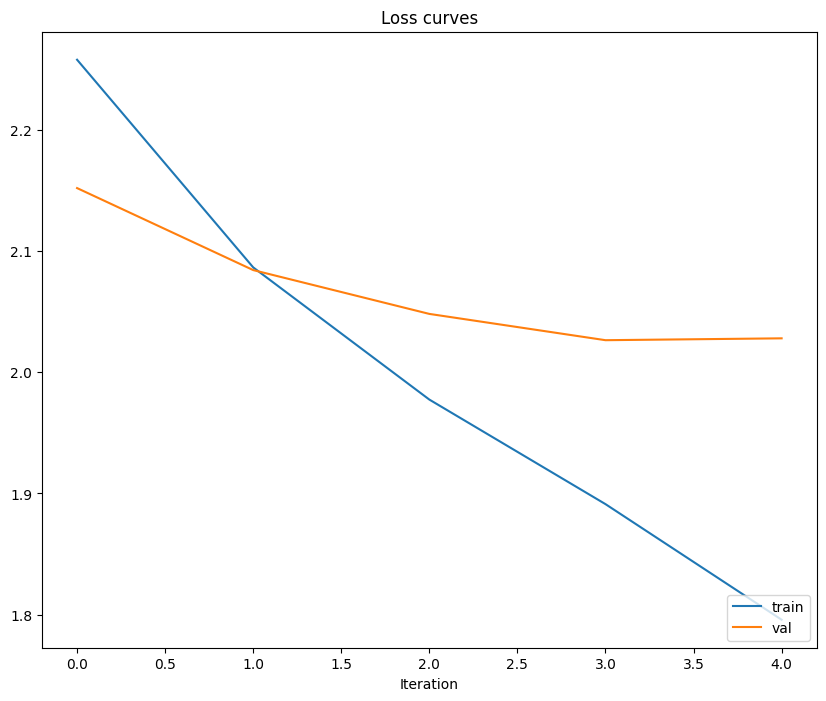

In [22]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [23]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(train_loader)))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val'])))

Training accuray: 0.46600
Validation accuray: 0.27815


In [24]:
from exercise_code.networks import MyOwnNetwork

num_layer = 5
epochs = 5
reg = 1e-4

model = ClassificationNet(num_layer=num_layer, reg=reg)
# model = MyOwnNetwork()

# Change here if you want to use the full training set
use_full_training_set = False
if not use_full_training_set:
    train_loader = dataloaders['train_small']
else:
    train_loader = dataloaders['train']

loss = CrossEntropyFromLogits

solver = Solver(model, train_loader, dataloaders['val'], 
                learning_rate=1e-3, loss_func=loss, optimizer=Adam)

solver.train(epochs=epochs)

(Epoch 1 / 5) train loss: 2.315489; val loss: 2.305227
(Epoch 2 / 5) train loss: 2.302554; val loss: 2.307221
(Epoch 3 / 5) train loss: 2.302796; val loss: 2.305772
(Epoch 4 / 5) train loss: 2.301402; val loss: 2.307386
(Epoch 5 / 5) train loss: 2.301414; val loss: 2.306428


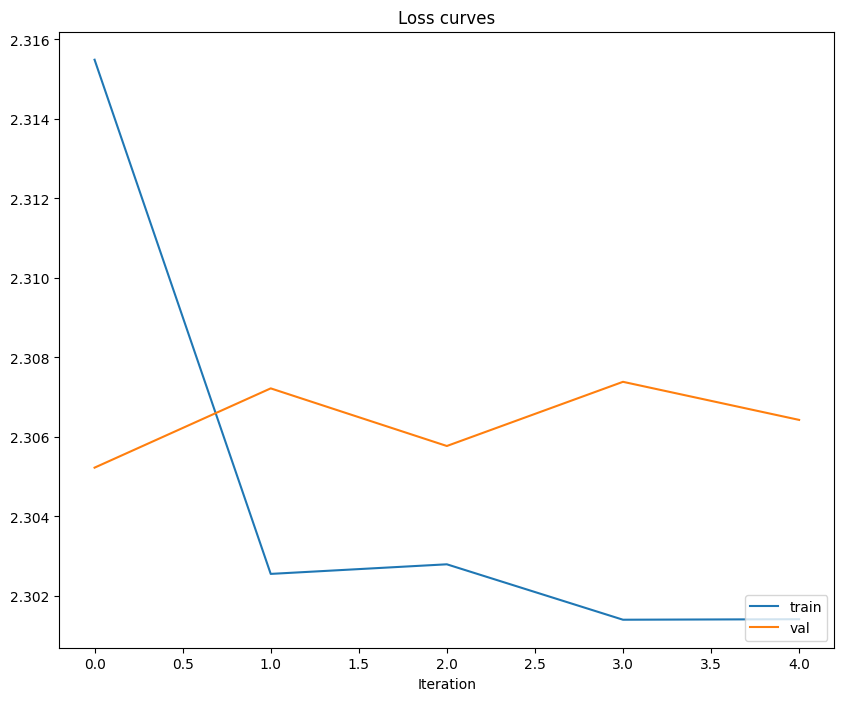

In [25]:
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

In [26]:
print("Training accuray: %.5f" % (solver.get_dataset_accuracy(train_loader)))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val'])))

Training accuray: 0.11600
Validation accuray: 0.09806


As you can see from above, the same hyperparameter set can decrease the loss for a 2-layer network, but for 5-layer network, it hardly works.

The steps above are already mentioned in the lectures as debugging steps before training a neural network. 

If you implement your own network, make sure you do the steps above before tuning the hyperparameters as below. 

## 2.2 Difficulty in tuning hyperparameters
Small decisions on hyperparameters count. Usually, but not always, hyperparameters cannot be learned using well known gradient based methods (such as gradient descent), which are commonly employed to learn parameters. 

As mentioned before, hyperparameters need to be set before training. Tuning hyperparameters is hard, because you always have to try different combinations of the hyperparameters, train the network, do the validation and pick the best one. Besides, it is not guaranteed that you'll find the best combination.

Let's do some hands on learning using the hyperparameter tuning methods covered in the lectures.

# 3. Hyperparameter Tuning

![alt text](https://blog.floydhub.com/content/images/2018/08/Screen-Shot-2018-08-22-at-17.59.25.png "")

One of the main challenges in deep learning is finding the set of hyperparameters that performs best.

So far, we have followed a manual approach by guessing hyperparameters, running the model, observing the result and maybe tweaking the hyperparameters based on this result. As you have probably noticed, this manual hyperparameter tuning is unstructured, inefficient and can become very tedious.


A more systematic (and actually very simple) approach for hyperparameter tuning that you've already learned in the lecture  is implementing a **Grid Search**. 



## 3.1 Grid Search
Grid search is a simple and naive, yet effective method to automate the hyperparameter tuning:

* First, you define the set of parameters you want to tune, e.g. $\{learning\_rate, regularization\_strength\}$.

* For each hyperparameter, you then define a set of possible values, e.g. $learning\_rate = \{0.0001, 0.001, 0.01, 0.1\}$.

* Then, you train a model for every possible combination of these hyperparameter values and afterwards select the combination that works best (e.g. in terms of accuracy on your validation set).

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Check out our <code>grid_search</code> implementation in <code>../exercise_6/exercise_code/hyperparameter_tuning.py</code>. We show a simple for loop implementation and a more sophisticated one for multiple inputs. </p>
</div>
 
 <div class="alert alert-warning">
    <h3>Note:</h3>
    <p>To keep things simple in the beginning, it'll be enough to just focus on the hyperparameters <code>learning_rate</code> and <code>regularization_strength</code> here, as in the example above.</p>
</div>

In [27]:
from exercise_code.networks import MyOwnNetwork

# Specify the used network
model_class = ClassificationNet

from exercise_code import hyperparameter_tuning
best_model, best_config, results  = hyperparameter_tuning.grid_search(
    dataloaders['train_small'], dataloaders['val_500files'],
    grid_search_spaces = {
        "learning_rate": [1e-2, 1e-3, 1e-4], 
        "reg": [1e-4]
    },
    model_class=model_class,
    epochs=10, patience=5)


Evaluating Config #1 [of 3]:
 {'learning_rate': 0.01, 'reg': 0.0001}
(Epoch 1 / 10) train loss: 2.530500; val loss: 2.354631
(Epoch 2 / 10) train loss: 2.500586; val loss: 2.499746
(Epoch 3 / 10) train loss: 2.652071; val loss: 2.749409
(Epoch 4 / 10) train loss: 2.727758; val loss: 2.797856
(Epoch 5 / 10) train loss: 2.849387; val loss: 3.125941
(Epoch 6 / 10) train loss: 2.864524; val loss: 3.219597
Stopping early at epoch 5!

Evaluating Config #2 [of 3]:
 {'learning_rate': 0.001, 'reg': 0.0001}
(Epoch 1 / 10) train loss: 2.271425; val loss: 2.166569
(Epoch 2 / 10) train loss: 2.098826; val loss: 2.030061
(Epoch 3 / 10) train loss: 1.974465; val loss: 1.983778
(Epoch 4 / 10) train loss: 1.871272; val loss: 1.935068
(Epoch 5 / 10) train loss: 1.766893; val loss: 1.933268
(Epoch 6 / 10) train loss: 1.693423; val loss: 1.946593
(Epoch 7 / 10) train loss: 1.594893; val loss: 1.905742
(Epoch 8 / 10) train loss: 1.512816; val loss: 1.914148
(Epoch 9 / 10) train loss: 1.412829; val loss: 1

From the results of your grid search, you might already have found some hyperparameter combinations that work better than others. A common practice is to now repeat the grid search on a more narrow domain centered around the parameters that worked best. 

**Conclusion Grid Search**

With grid search we have automated the hyperparameter tuning to a certain degree. Another advantage is, that since the trainings of the models are independent of each other, you can parallelize the grid search, by e.g. trying out different hyperparameter configurations in parallel on different machines.

However, as you have probably noticed, there is one big problem with this approach: the number of possible combinations grows exponentially with the number of hyperparameters ("curse of dimensionality"). As we add more hyperparameters to the grid search, the search space will explode in time complexity, making this strategy unfeasible.

Especially when your search space contains more than 3 or 4 dimensions, it is often better to use another, similar hyperparameter tuning method that you've already learned about: random search.

## 3.2 Random Search
Random search is very similar to grid search, with the only difference, that instead of providing specific values for every hyperparameter, you only define a range for each hyperparameter - then, the values are sampled randomly from the provided ranges.

![alt text](https://i.stack.imgur.com/cIDuR.png "")

The figure above illustrates the difference in the hyperparameter space exploration between grid search and random search: assume you have 2 hyperparameters with each 3 values. Running a grid search results in training $3^2=9$ different models - but in the end, you've just tired out 3 values for each parameter. For random search on the other hand, after training 9 models you'll have tried out 9 different values for each hyperparameter, which often leads much faster to good results.

To get a deeper understanding of random search and why it is more efficient than grid search, you should definitely check out this paper: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Check out our <code>random_search</code> implementation in <code>../exercise_6/exercise_code/hyperparameter_tuning.py</code></p>
</div>


*Hint: regarding the sample space of each parameter, think about the scale for which it makes most sense to sample in. For example the learning rate is usually sampled on a logarithmic scale!*

*For simplicity and speed, just use the `train_small`-dataloader!*

In [ ]:
from exercise_code.hyperparameter_tuning import random_search
from exercise_code.networks import MyOwnNetwork

# Specify the used network
model_class = ClassificationNet

best_model, best_config, results  = random_search(
    dataloaders['train_small'], dataloaders['val_500files'],
    random_search_spaces = {
        "learning_rate": ([1e-2, 1e-6], 'log'),
        "reg": ([1e-3, 1e-7], "log"),
        "loss_func": ([CrossEntropyFromLogits], "item")
    },
    model_class=model_class,
    num_search = 1, epochs=20, patience=5)

It's time to run it with the whole dataset, and let it search for a few hours for a nice configuration. 

However, to save some time, let's first implement an **early-stopping** mechanism, that you also already know from the lecture.

## 3.3 Early Stopping

By now you've already seen a lot of training curves:

<img src=http://fouryears.eu/wp-content/uploads/2017/12/early_stopping.png></img>

Usually, at some point the validation loss goes up again, which is a sign that we're overfitting to our training data. Since it actually doesn't make sense to train further at this point, it's common practice to apply "early stopping", i.e., cancel the training process when the validation loss doesn't improve anymore. The nice thing about this concept is, that not only it improves generalization through the prevention of overfitting, but also it saves us a lot of time - one of our most valuable resources in deep learning.

Since there are natural fluctuations in the validation loss, you usually don't cancel the training process right at the first epoch when the validation-loss increases, but instead, you wait for some epochs (specified by the `patience`-parameter) and if the loss still doesn't improve, we stop.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check the implementation of the early stopping mechanism in <code>../exercise_6/exercise_code/solver.py</code>.
 </p>
</div>

## 3.4 Let's find the perfect model!

Now you've set everything up and you are ready to train your model. You can use a combination of grid and random search to find proper hyperparameters. 

Be aware that this process will take some time, since we'll be using a much larger dataset.

At the beginning, it is a good approach to do a coarse random search across a wide range of values to find promising sub-ranges of your parameter space. Afterwards, you can zoom into these ranges and perform another random search (or grid search) to finetune the configurations.

To save time and resources, don't use the whole dataset at the beginning, but instead a medium large subset of the samples. Also, you don't have to train for a large number of epochs - as mentioned above: we first want to get an overview about our hyper parameters.

<div class="alert alert-info">
    <h3>Task: Hyperparameters Tunning & Model Training </h3>
        <p> Now, it is your turn to do the hyperparamater tuning. In the cell below, you can use the <code>random_search</code> function to find a good choice of parameters. Put in some reasonable ranges for the hyperparameters and evaluate them.
    <p> <b>Note:</b> At the beginning, it's a good approach to first do a coarse random search across a <b> wide range of values</b> to find promising sub-ranges of your parameter space and use <b> a medium large subset of the dataset </b>. Afterwards, you can zoom into these ranges and do another random search (or grid search) to finetune the configurations. Use the cell below to play around and find good hyperparameters for your model!</p>
        <p> Finally, once you've found some promising hyperparameters (or narrowed them down to promising subranges), it's time to utilize these hyperparameters to train your network on the whole dataset for a large number of epochs so that your own model can reach an acceptable performance. 
        <p> <b>Hint 1:</b> You may use a <code>Solver</code> class we provided before or directly use the <code>random_search</code> function (as you can also monitor the loss here) for model training.
        <p> <b>Hint 2:</b> Be patience, this will time.
        <p> <b>Hint 3:</b> It is a better practice to find good set of hyperparameters on the small datasets, and only then run a full training session on the full dataset, either with specifc hyperparameters that you've found in the <code>random search</code>, or better ranges.
</div>

In [ ]:
from exercise_code.networks import MyOwnNetwork, ClassificationNet


model_type = ClassificationNet
#model_type = MyOwnNetwork

########################################################################
# TODO:                                                                #
# Implement your own neural network and find suitable hyperparameters  #
# Be sure to edit the MyOwnNetwork class in the following code snippet #
# to upload the correct model! Or just use the given                   #
# "ClassificationNet".                                                 #
#                                                                      #
# Note: the pickling cell expects your model to be named "best_model". #
# Unless you change it there, naming the best model in any other way   #
# will result in an unknown behavior.                                  #
########################################################################


pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

Now it's time to edit the ranges above and adjust them to explore regions that performed well!

Also, feel free to experiment around. Other hyperparameters you can change are the network architecture, optimizer, activations functions and many more.

Try to get an accuracy as high as possible, since that's all what counts for this submission!

You'll pass if you reach at least **48%** accuracy on our test set - but there will also be a leaderboard of all students of this course. Can you make it to the top?

## 3.5 Checking the validation accuracy

In [ ]:
from exercise_code.tests.base_tests import bcolors

labels, pred, acc = best_model.get_dataset_prediction(dataloaders['train'])
res = bcolors.colorize("green", acc * 100) if acc * 100 > 48 else bcolors.colorize("red", acc * 100)
print("Train Accuracy: {}%".format(res))
labels, pred, acc = best_model.get_dataset_prediction(dataloaders['val'])
res = bcolors.colorize("green", acc * 100) if acc * 100 > 48 else bcolors.colorize("red", acc * 100)
print("Validation Accuracy: {}%".format(res))

# 4. Test your model
When you have finished the hyperparameter tuning and you found your final model which performs well on the validation set (**you should at least get 48% accuracy on the validation set!**), it's time to run your model on the test set.

<div class="alert alert-danger">
    <h3>Important</h3>
    <p>As you have learned in the lecture, you must only use the test set once! So only run the next cell if you are completely sure that your model works well enough and that you are ready to submit. Your test set is different from the test set on our server, so results may vary a bit. Nevertheless, you will get a reasonable approximation of your model's performance if you perform the final evaluation on the test set only once.</p>
    <p>If you are an external student that can't use our submission webpage: this test performance is your final result and if you surpassed the threshold, you have completed this exercise :). Now, train again to aim for a better number!</p>
</div>

In [ ]:
# comment this part out to see your model's performance on the test set.
labels, pred, acc = best_model.get_dataset_prediction(dataloaders['test'])
res = bcolors.colorize("green", acc * 100) if acc * 100 > 48 else bcolors.colorize("red", acc * 100)
print("Test Accuracy: {}%".format(res))


<div class="alert alert-warning">
    <h3>Note:</h3>
    <p>The "real" test set is actually the dataset we're using for testing your model, which is <b>different</b> from the test-set you're using here.</p>
</div>

# 5. Saving your Model

In [ ]:
from exercise_code.networks import MyOwnNetwork, ClassificationNet
from exercise_code.networks.layer import (
    Sigmoid, 
    Relu, 
    LeakyRelu, 
    Tanh,
)

In [ ]:
from exercise_code.tests import save_pickle
best_model.eval()
save_pickle({"cifar_fcn": best_model}, "cifar_fcn.p")

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise_06')

# 6. Submission Instructions

Congratulations! You've just built your first image classifier! To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.vc.in.tum.de/submission/), register for an account and login. We use your matriculation number and send you an email with the login details to the associated mail account. When in doubt, login into tum-online and check your mails there. You will get an id which we'll need in the next step.
2. Log into [our submission page](https://i2dl.vc.in.tum.de/submission/), with your account details and upload the zip file.
3. Your submission will be evaluated by our system and you will get feedback about the performance of it. You will get an email with your score, as well as a message if you have surpassed the threshold or not.
4. Within the working period, you can submit as many solutions as you want to get the best possible score.


# 7. Submission Goals

- Goal: Successfully implement a fully connected NN image classifier and tune the hyperparameters.

- Passing Criteria: This time, there are no unit tests checking specific components of your code. To  pass the submission your model needs to reach at least **48% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.

- Submission start: __May 23rd, 2024 10:00__
- Submission deadline : __May 29th, 2023 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for the bonus.